In [1]:
import torch
import requests

import numpy as np
import supervision as sv
import albumentations as A

from PIL import Image
from pprint import pprint
from dataclasses import dataclass, replace
from torch.utils.data import Dataset
from transformers import (
    AutoImageProcessor,
    AutoModelForObjectDetection,
    TrainingArguments,
    Trainer
)
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [2]:
# @title Load model

CHECKPOINT = "PekingU/rtdetr_r50vd_coco_o365"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForObjectDetection.from_pretrained(CHECKPOINT).to(DEVICE)
processor = AutoImageProcessor.from_pretrained(CHECKPOINT)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [3]:
# @title Run inference

URL = "https://media.roboflow.com/notebooks/examples/dog.jpeg"

image = Image.open(requests.get(URL, stream=True).raw)
inputs = processor(image, return_tensors="pt").to(DEVICE)

with torch.no_grad():
    outputs = model(**inputs)

w, h = image.size
results = processor.post_process_object_detection(
    outputs, target_sizes=[(h, w)], threshold=0.3)

In [4]:
# # @title Display result with NMS

# detections = sv.Detections.from_transformers(results[0])
# labels = [
#     model.config.id2label[class_id]
#     for class_id
#     in detections.class_id
# ]

# annotated_image = image.copy()
# annotated_image = sv.BoundingBoxAnnotator().annotate(annotated_image, detections)
# annotated_image = sv.LabelAnnotator().annotate(annotated_image, detections, labels=labels)
# annotated_image.thumbnail((600, 600))
# annotated_image

In [5]:
location = 'coco'
import supervision as sv

# ds_train = sv.DetectionDataset.from_coco(
#     images_directory_path=f"{location}/train",
#     annotations_path=f"{location}/train/_annotations.coco.json",
# )
# ds_valid = sv.DetectionDataset.from_coco(
#     images_directory_path=f"{location}/valid",
#     annotations_path=f"{location}/valid/_annotations.coco.json",
# )
# ds_test = sv.DetectionDataset.from_coco(
#     images_directory_path=f"{location}/test",
#     annotations_path=f"{location}/test/_annotations.coco.json",
# )

ds_train = sv.DetectionDataset.from_coco(
    images_directory_path=f"{location}/train",
    annotations_path=f"{location}/train/_annotations.coco.json",
)
ds_valid = sv.DetectionDataset.from_coco(
    images_directory_path=f"{location}/valid",
    annotations_path=f"{location}/valid/_annotations.coco.json",
)
ds_test = sv.DetectionDataset.from_coco(
    images_directory_path=f"{location}/test",
    annotations_path=f"{location}/test/_annotations.coco.json",
)

print(f"Number of training images: {len(ds_train)}")
print(f"Number of validation images: {len(ds_valid)}")
print(f"Number of test images: {len(ds_test)}")

Number of training images: 591
Number of validation images: 49
Number of test images: 49


In [6]:
# # @title Display dataset sample

# GRID_SIZE = 5

# def annotate(image, annotations, classes):
#     labels = [
#         classes[class_id]
#         for class_id
#         in annotations.class_id
#     ]

#     bounding_box_annotator = sv.BoundingBoxAnnotator()
#     label_annotator = sv.LabelAnnotator(text_scale=1, text_thickness=2)

#     annotated_image = image.copy()
#     annotated_image = bounding_box_annotator.annotate(annotated_image, annotations)
#     annotated_image = label_annotator.annotate(annotated_image, annotations, labels=labels)
#     return annotated_image

# annotated_images = []
# for i in range(GRID_SIZE * GRID_SIZE):
#     _, image, annotations = ds_train[i]
#     annotated_image = annotate(image, annotations, ds_train.classes)
#     annotated_images.append(annotated_image)

# grid = sv.create_tiles(
#     annotated_images,
#     grid_size=(GRID_SIZE, GRID_SIZE),
#     single_tile_size=(400, 400),
#     tile_padding_color=sv.Color.WHITE,
#     tile_margin_color=sv.Color.WHITE
# )
# sv.plot_image(grid, size=(10, 10))

In [7]:
import albumentations as A

augmentation_train = A.Compose(
    [
        A.Perspective(p=0.1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1),
    ],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["category"],
        clip=True,
        min_area=25
    ),
)

augmentation_valid = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["category"],
        clip=True,
        min_area=1
    ),
)

In [8]:
from dataclasses import replace
import numpy as np

IMAGE_COUNT = 5

for i in range(IMAGE_COUNT):
    _, image, annotations = ds_train[i]

    output = augmentation_train(
        image=image,
        bboxes=annotations.xyxy,
        category=annotations.class_id
    )

    augmented_image = output["image"]
    augmented_annotations = replace(
        annotations,
        xyxy=np.array(output["bboxes"]),
        class_id=np.array(output["category"])
    )

In [9]:
from torch.utils.data import Dataset

class AugmentedDetectionDataset(Dataset):
    def __init__(self, dataset, processor, transform):
        self.dataset = dataset
        self.processor = processor
        self.transform = transform

    @staticmethod
    def annotations_as_coco(image_id, categories, boxes):
        ...

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        _, image, annotations = self.dataset[idx]

        image = image[:, :, ::-1]
        transformed = self.transform(
            image=image,
            bboxes=annotations.xyxy,
            category=annotations.class_id
        )
        image = transformed["image"]
        boxes = transformed["bboxes"]
        categories = transformed["category"]

        formatted_annotations = self.annotations_as_coco(
            image_id=idx, 
            categories=categories, 
            boxes=boxes
        )
        result = self.processor(
            images=image, 
            annotations=formatted_annotations, 
            return_tensors="pt"
        )

        return {k: v[0] for k, v in result.items()}

In [10]:
IMAGE_SIZE = 480

processor = AutoImageProcessor.from_pretrained(
    CHECKPOINT,
    do_resize=True,
    size={"width": IMAGE_SIZE, "height": IMAGE_SIZE},
)

In [11]:
train_augmentation_and_transform = A.Compose(
    [
        A.Perspective(p=0.1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1),
    ],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["category"],
        clip=True,
        min_area=25
    ),
)

valid_transform = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["category"],
        clip=True,
        min_area=1
    ),
)

In [12]:
# # @title Visualize some augmented images

# IMAGE_COUNT = 5

# for i in range(IMAGE_COUNT):
#     _, image, annotations = ds_train[i]

#     output = train_augmentation_and_transform(
#         image=image,
#         bboxes=annotations.xyxy,
#         category=annotations.class_id
#     )

#     augmented_image = output["image"]
#     augmented_annotations = replace(
#         annotations,
#         xyxy=np.array(output["bboxes"]),
#         class_id=np.array(output["category"])
#     )

#     annotated_images = [
#         annotate(image, annotations, ds_train.classes),
#         annotate(augmented_image, augmented_annotations, ds_train.classes)
#     ]
#     grid = sv.create_tiles(
#         annotated_images,
#         titles=['original', 'augmented'],
#         titles_scale=0.5,
#         single_tile_size=(400, 400),
#         tile_padding_color=sv.Color.WHITE,
#         tile_margin_color=sv.Color.WHITE
#     )
#     sv.plot_image(grid, size=(6, 6))

In [13]:
class PyTorchDetectionDataset(Dataset):
    def __init__(self, dataset: sv.DetectionDataset, processor, transform: A.Compose = None):
        self.dataset = dataset
        self.processor = processor
        self.transform = transform

    @staticmethod
    def annotations_as_coco(image_id, categories, boxes):
        annotations = []
        for category, bbox in zip(categories, boxes):
            x1, y1, x2, y2 = bbox
            formatted_annotation = {
                "image_id": image_id,
                "category_id": category,
                "bbox": [x1, y1, x2 - x1, y2 - y1],
                "iscrowd": 0,
                "area": (x2 - x1) * (y2 - y1),
            }
            annotations.append(formatted_annotation)

        return {
            "image_id": image_id,
            "annotations": annotations,
        }

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        _, image, annotations = self.dataset[idx]

        # Convert image to RGB numpy array
        image = image[:, :, ::-1]
        boxes = annotations.xyxy
        categories = annotations.class_id

        if self.transform:
            transformed = self.transform(
                image=image,
                bboxes=boxes,
                category=categories
            )
            image = transformed["image"]
            boxes = transformed["bboxes"]
            categories = transformed["category"]


        formatted_annotations = self.annotations_as_coco(
            image_id=idx, categories=categories, boxes=boxes)
        result = self.processor(
            images=image, annotations=formatted_annotations, return_tensors="pt")

        # Image processor expands batch dimension, lets squeeze it
        result = {k: v[0] for k, v in result.items()}

        return result

In [14]:
pytorch_dataset_train = PyTorchDetectionDataset(
    ds_train, processor, transform=train_augmentation_and_transform)
pytorch_dataset_valid = PyTorchDetectionDataset(
    ds_valid, processor, transform=valid_transform)
pytorch_dataset_test = PyTorchDetectionDataset(
    ds_test, processor, transform=valid_transform)

pytorch_dataset_train[15]

{'pixel_values': tensor([[[0.2431, 0.2392, 0.2353,  ..., 0.3255, 0.3216, 0.3216],
          [0.2392, 0.2392, 0.2314,  ..., 0.3255, 0.3216, 0.3216],
          [0.2314, 0.2314, 0.2275,  ..., 0.3255, 0.3216, 0.3216],
          ...,
          [0.1333, 0.1333, 0.1333,  ..., 0.1373, 0.1373, 0.1373],
          [0.1333, 0.1333, 0.1333,  ..., 0.1373, 0.1373, 0.1373],
          [0.1333, 0.1333, 0.1333,  ..., 0.1373, 0.1373, 0.1373]],
 
         [[0.2431, 0.2392, 0.2353,  ..., 0.3255, 0.3216, 0.3216],
          [0.2392, 0.2392, 0.2314,  ..., 0.3255, 0.3216, 0.3216],
          [0.2314, 0.2314, 0.2275,  ..., 0.3255, 0.3216, 0.3216],
          ...,
          [0.1333, 0.1333, 0.1333,  ..., 0.1373, 0.1373, 0.1373],
          [0.1333, 0.1333, 0.1333,  ..., 0.1373, 0.1373, 0.1373],
          [0.1333, 0.1333, 0.1333,  ..., 0.1373, 0.1373, 0.1373]],
 
         [[0.2431, 0.2392, 0.2353,  ..., 0.3255, 0.3216, 0.3216],
          [0.2392, 0.2392, 0.2314,  ..., 0.3255, 0.3216, 0.3216],
          [0.2314, 0.231

In [15]:
def collate_fn(batch):
    data = {}
    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])
    data["labels"] = [x["labels"] for x in batch]
    return data

id2label = {id: label for id, label in enumerate(ds_train.classes)}
label2id = {label: id for id, label in enumerate(ds_train.classes)}


@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor

class MAPEvaluator:
    def __init__(self, image_processor, threshold=0.00, id2label=None, assume_square_if_needed=True):
        self.image_processor = image_processor
        self.threshold = threshold
        self.id2label = id2label
        self.assume_square_if_needed = assume_square_if_needed

    # ---- helpers ----
    def _extract_hw(self, target):
        """
        Return (H, W) for this sample. Prefer orig_size if available.
        Accepts common shapes: list/tuple/np/torch, dict{'height','width'}, or ints.
        """
        # 1) HuggingFace DETR-style original size
        for key in ("orig_size", "original_size"):
            if key in target:
                arr = np.array(target[key]).reshape(-1)
                if arr.size >= 2:
                    return int(arr[0]), int(arr[1])

        # 2) Explicit fields
        if all(k in target for k in ("height", "width")):
            return int(target["height"]), int(target["width"])

        # 3) 'size' field in various shapes
        if "size" in target:
            s = target["size"]
            if isinstance(s, dict) and {"height","width"} <= s.keys():
                return int(s["height"]), int(s["width"])
            arr = np.array(s).reshape(-1)
            if arr.size >= 2:
                return int(arr[0]), int(arr[1])
            if arr.size == 1 and self.assume_square_if_needed:
                # Last resort: treat single value as square (H=W)
                h = int(arr[0])
                return h, h

        raise ValueError(f"Cannot determine (H, W) for target; got keys {list(target.keys())}")

    def _build_image_sizes_and_targets(self, targets):
        """
        From nested targets (list of batches), build:
          - image_sizes: [tensor([ [H,W], ... ]), ...]
          - post_processed_targets: list of dicts with absolute pixel 'boxes' and 'labels'
        """
        image_sizes_batches = []
        post_processed_targets = []

        for target_batch in targets:
            sizes_this_batch = []
            for target in target_batch:
                H, W = self._extract_hw(target)
                sizes_this_batch.append([H, W])

                boxes = target["boxes"]  # expected x_center,y_center,w,h in [0,1] or normalized
                boxes = sv.xcycwh_to_xyxy(boxes)
                boxes = boxes * np.array([W, H, W, H])   # scale to absolute pixels
                boxes = torch.tensor(boxes, dtype=torch.float32)

                labels = torch.tensor(target["class_labels"], dtype=torch.int64)
                post_processed_targets.append({"boxes": boxes, "labels": labels})

            image_sizes_batches.append(torch.tensor(sizes_this_batch, dtype=torch.int64))
        return image_sizes_batches, post_processed_targets

    def collect_predictions(self, predictions, image_sizes):
        post_processed_predictions = []
        for batch, target_sizes in zip(predictions, image_sizes):
            # Adjust indexing here to match your predictions structure
            batch_logits, batch_boxes = batch[1], batch[2]
            output = ModelOutput(
                logits=torch.tensor(batch_logits),
                pred_boxes=torch.tensor(batch_boxes)
            )
            post = self.image_processor.post_process_object_detection(
                output, threshold=self.threshold, target_sizes=target_sizes
            )
            post_processed_predictions.extend(post)
        return post_processed_predictions

    @torch.no_grad()
    def __call__(self, evaluation_results):
        predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

        image_sizes, post_processed_targets = self._build_image_sizes_and_targets(targets)
        post_processed_predictions = self.collect_predictions(predictions, image_sizes)

        evaluator = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
        evaluator.warn_on_many_detections = False
        evaluator.update(post_processed_predictions, post_processed_targets)

        metrics = evaluator.compute()

        # Per-class metrics
        classes = metrics.pop("classes")
        map_per_class = metrics.pop("map_per_class")
        mar_100_per_class = metrics.pop("mar_100_per_class")
        for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
            class_name = self.id2label[class_id.item()] if self.id2label is not None else class_id.item()
            metrics[f"map_{class_name}"] = class_map
            metrics[f"mar_100_{class_name}"] = class_mar

        metrics = {k: round(v.item(), 4) for k, v in metrics.items()}
        return metrics


eval_compute_metrics_fn = MAPEvaluator(image_processor=processor, threshold=0.01, id2label=id2label)

In [16]:
model = AutoModelForObjectDetection.from_pretrained(
    CHECKPOINT,
    id2label=id2label,
    label2id=label2id,
    anchor_image_size=None,
    ignore_mismatched_sizes=True,
)

Some weights of RTDetrForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_r50vd_coco_o365 and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([2]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([2]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([2]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- model.

In [17]:
training_args = TrainingArguments(
    output_dir=f"coco-finetune",
    num_train_epochs=20,
    max_grad_norm=0.1,
    learning_rate=5e-5,
    warmup_steps=300,
    per_device_train_batch_size=2,
    dataloader_num_workers=2,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    eval_do_concat_batches=False,
)

In [18]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=pytorch_dataset_train,
    eval_dataset=pytorch_dataset_valid,
    tokenizer=processor,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
)

trainer.train()

There were missing keys in the checkpoint model loaded: ['class_embed.0.weight', 'class_embed.0.bias', 'class_embed.1.weight', 'class_embed.1.bias', 'class_embed.2.weight', 'class_embed.2.bias', 'class_embed.3.weight', 'class_embed.3.bias', 'class_embed.4.weight', 'class_embed.4.bias', 'class_embed.5.weight', 'class_embed.5.bias', 'bbox_embed.0.layers.0.weight', 'bbox_embed.0.layers.0.bias', 'bbox_embed.0.layers.1.weight', 'bbox_embed.0.layers.1.bias', 'bbox_embed.0.layers.2.weight', 'bbox_embed.0.layers.2.bias', 'bbox_embed.1.layers.0.weight', 'bbox_embed.1.layers.0.bias', 'bbox_embed.1.layers.1.weight', 'bbox_embed.1.layers.1.bias', 'bbox_embed.1.layers.2.weight', 'bbox_embed.1.layers.2.bias', 'bbox_embed.2.layers.0.weight', 'bbox_embed.2.layers.0.bias', 'bbox_embed.2.layers.1.weight', 'bbox_embed.2.layers.1.bias', 'bbox_embed.2.layers.2.weight', 'bbox_embed.2.layers.2.bias', 'bbox_embed.3.layers.0.weight', 'bbox_embed.3.layers.0.bias', 'bbox_embed.3.layers.1.weight', 'bbox_embed.3.l

TrainOutput(global_step=5920, training_loss=20.717790180928, metrics={'train_runtime': 11358.5261, 'train_samples_per_second': 1.041, 'train_steps_per_second': 0.521, 'total_flos': 2.094635890169856e+18, 'train_loss': 20.717790180928, 'epoch': 20.0})

In [38]:
# @title Collect predictions

targets = []
predictions = []

for i in range(len(ds_test)):
    path, sourece_image, annotations = ds_test[i]

    image = Image.open(path)
    inputs = processor(image, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(**inputs)

    w, h = image.size
    results = processor.post_process_object_detection(
        outputs, target_sizes=[(h, w)], threshold=0.05)

    detections = sv.Detections.from_transformers(results[0])

    targets.append(annotations)
    predictions.append(detections)

In [39]:
# @title Calculate mAP
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

map50_95: 0.40
map50: 0.80
map75: 0.30


SupervisionWarnings: MeanAveragePrecision is deprecated: `MeanAveragePrecision` is deprecated and will be removed in `supervision-0.31.0`. Use `supervision.metrics.mean_average_precision.MeanAveragePrecision` instead. The deprecated implementation provides results that are inconsistent with pycocotools.


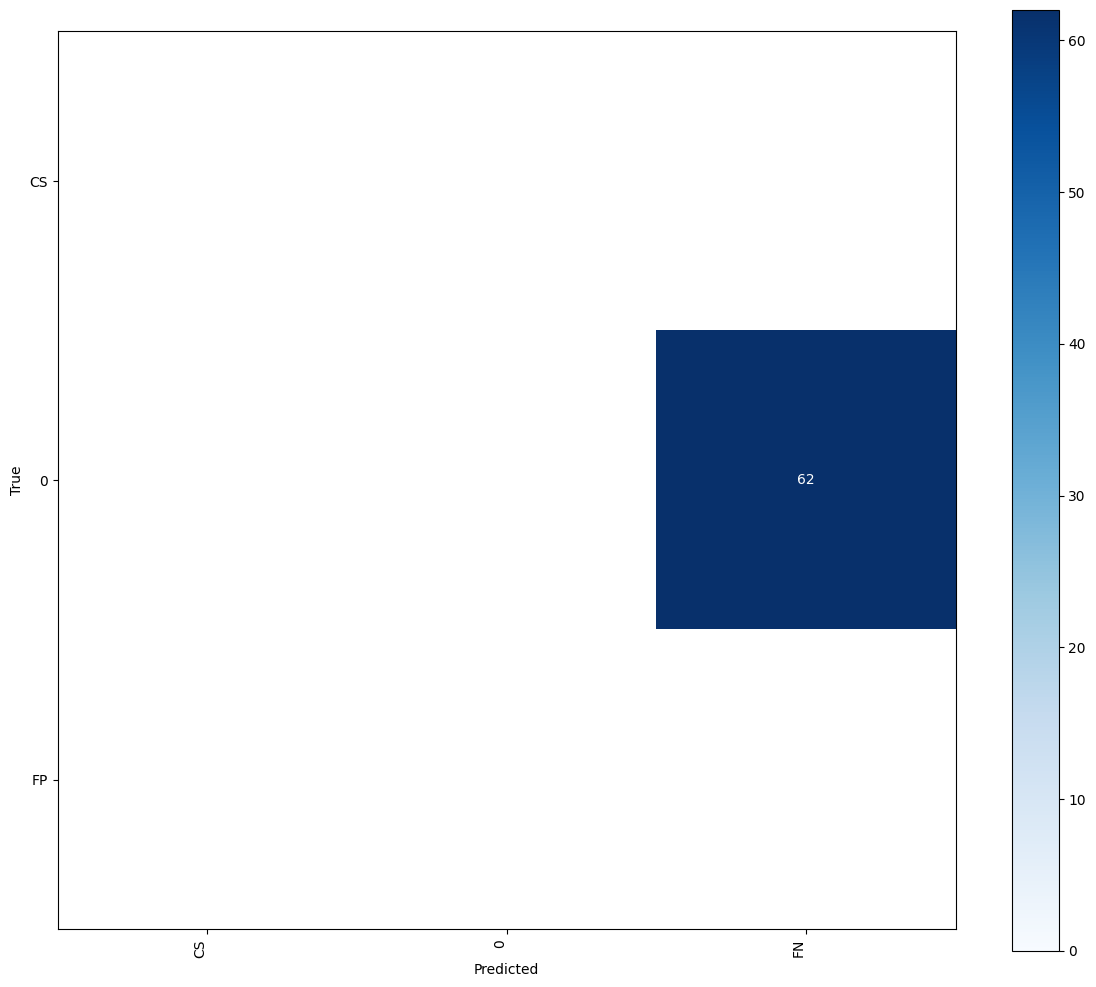

In [40]:
# @title Calculate Confusion Matrix
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=ds_test.classes
)

_ = confusion_matrix.plot()

In [42]:
model.save_pretrained("rt-detr/")
processor.save_pretrained("rt-detr/")

['rt-detr/preprocessor_config.json']

In [50]:
# @title Display dataset sample

GRID_SIZE = 5

def annotate(image, annotations, classes):
    labels = [
        classes[class_id]
        for class_id
        in annotations.class_id
    ]

    bounding_box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator(text_scale=1, text_thickness=2)

    annotated_image = image.copy()
    annotated_image = bounding_box_annotator.annotate(annotated_image, annotations)
    annotated_image = label_annotator.annotate(annotated_image, annotations, labels=labels)
    return annotated_image

# annotated_images = []
# for i in range(GRID_SIZE * GRID_SIZE):
#     _, image, annotations = ds_train[i]
#     annotated_image = annotate(image, annotations, ds_train.classes)
#     annotated_images.append(annotated_image)

# grid = sv.create_tiles(
#     annotated_images,
#     grid_size=(GRID_SIZE, GRID_SIZE),
#     single_tile_size=(400, 400),
#     tile_padding_color=sv.Color.WHITE,
#     tile_margin_color=sv.Color.WHITE
# )
# sv.plot_image(grid, size=(10, 10))

In [ ]:
sv.BoxAnnotator

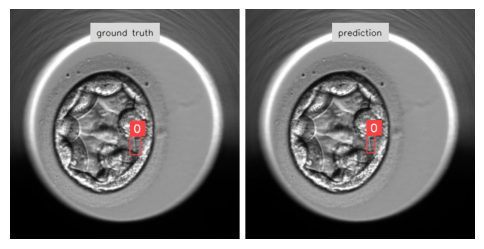

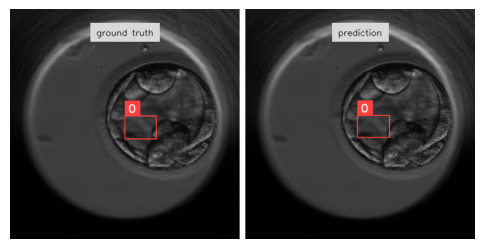

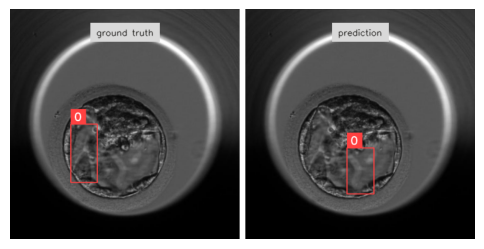

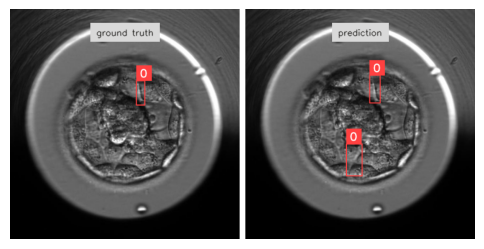

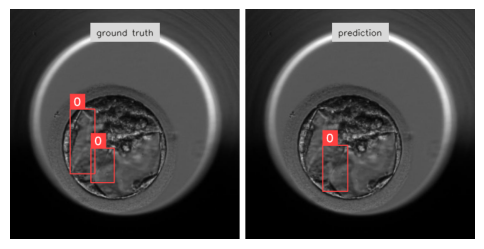

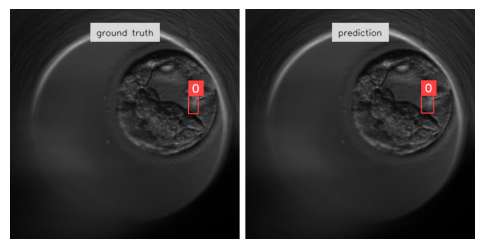

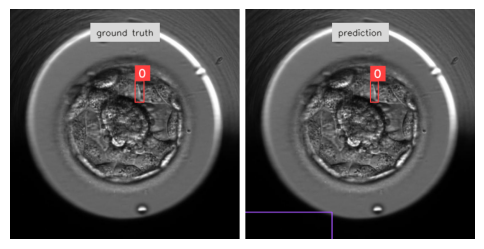

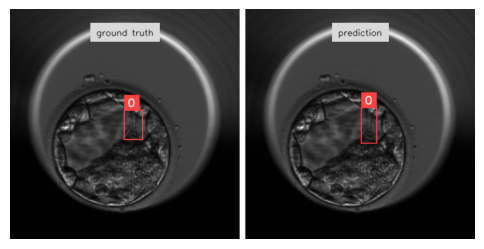

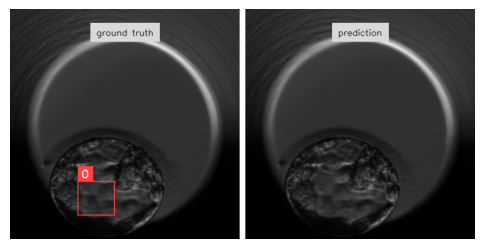

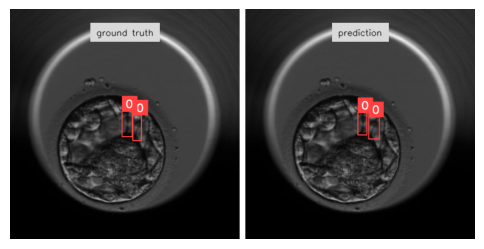

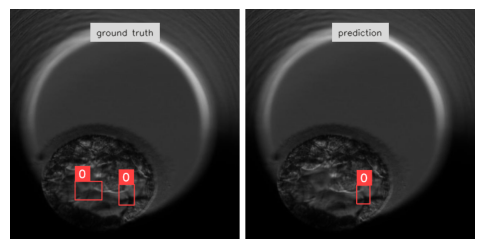

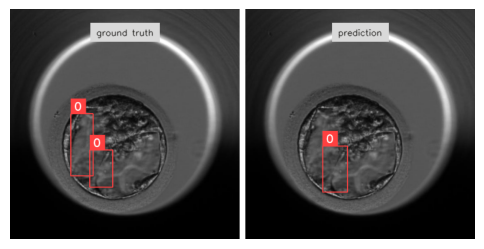

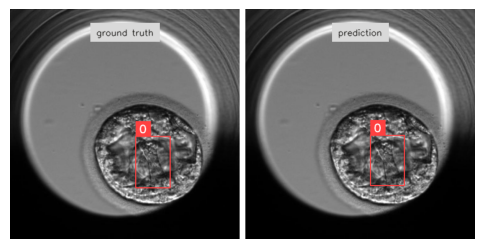

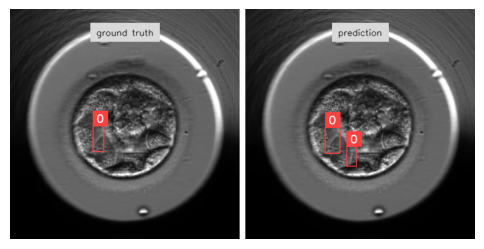

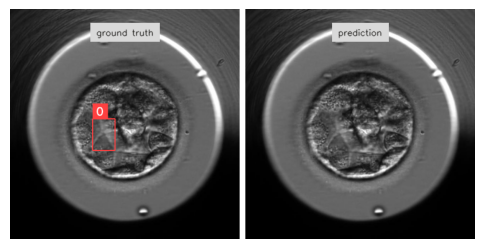

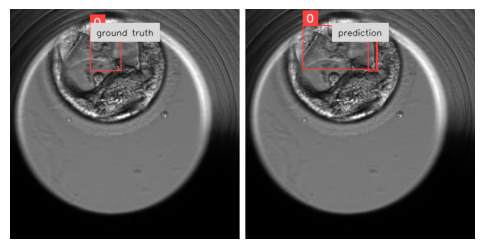

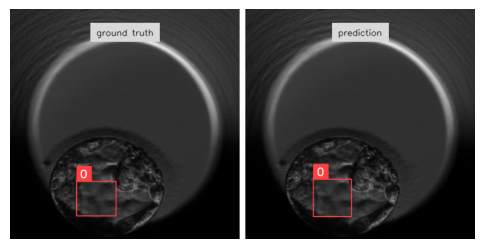

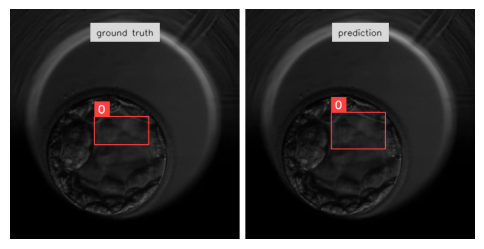

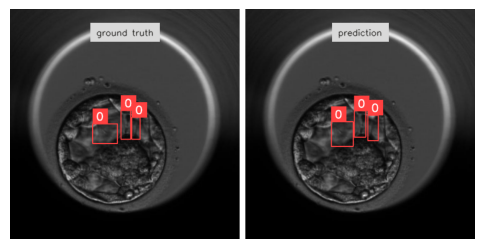

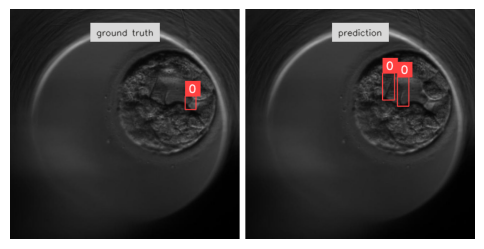

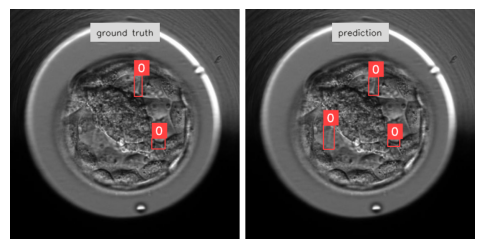

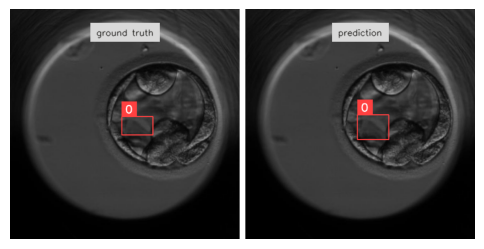

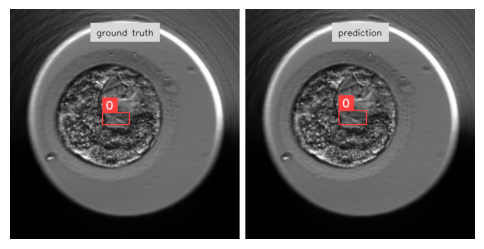

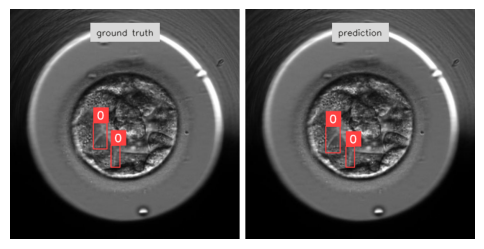

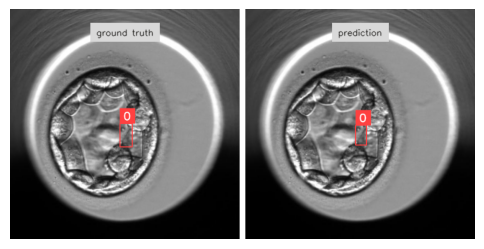

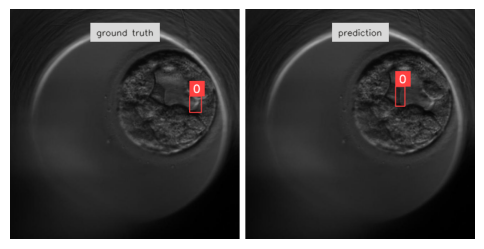

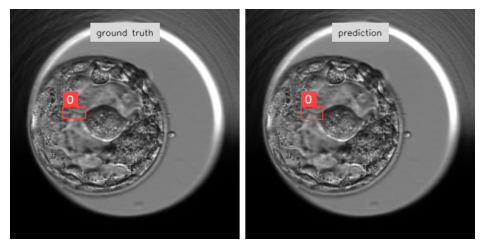

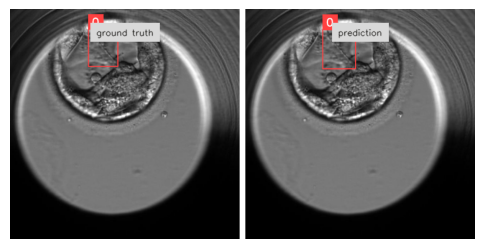

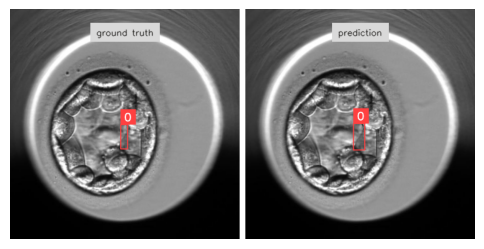

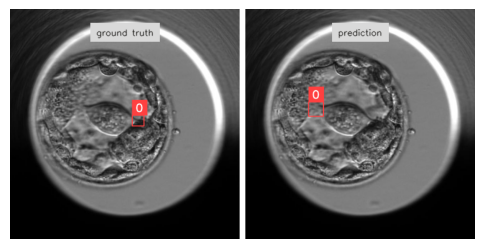

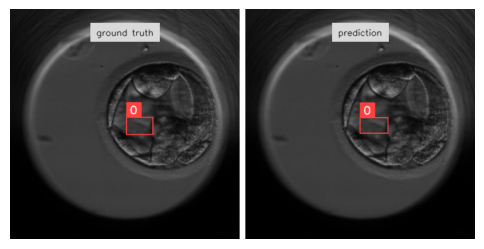

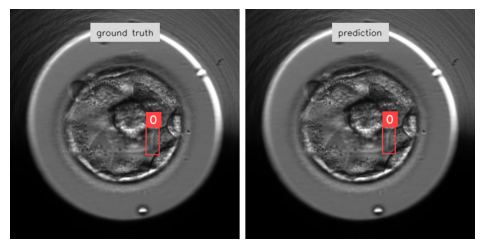

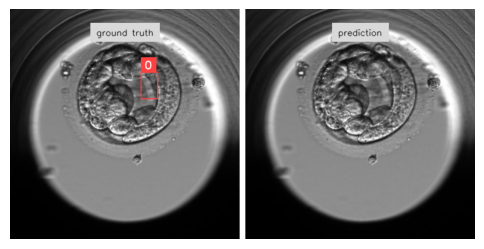

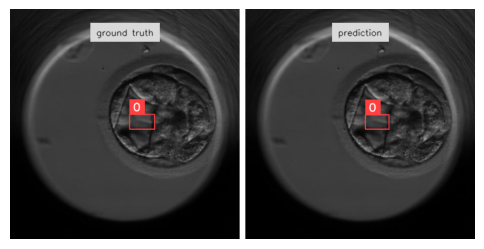

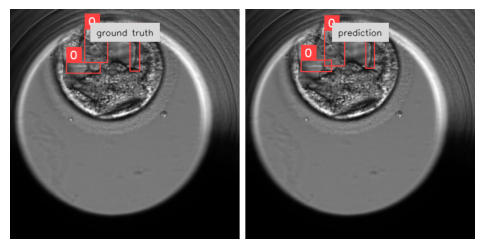

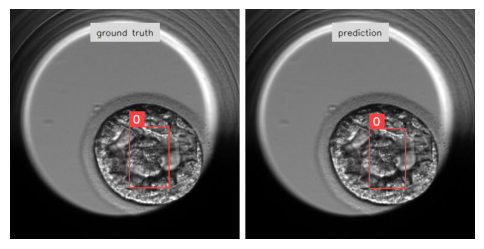

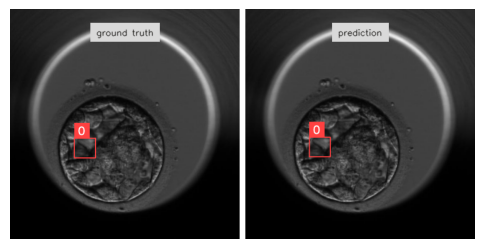

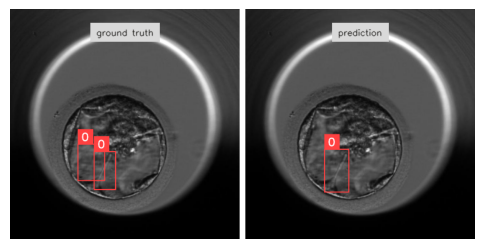

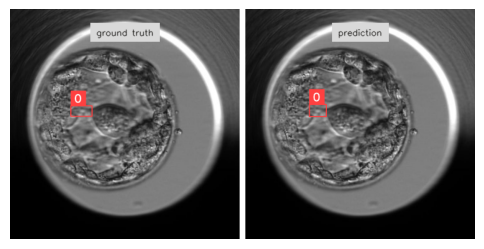

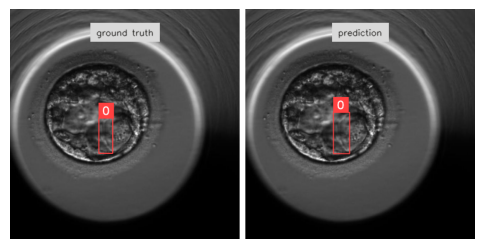

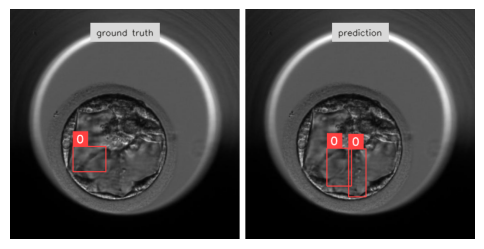

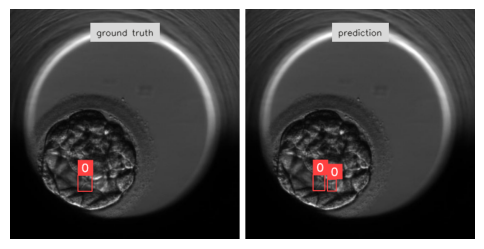

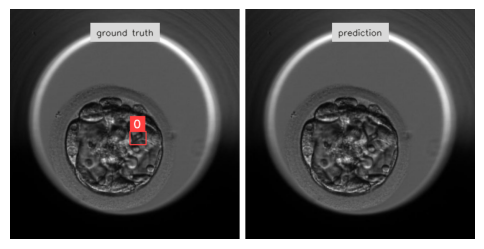

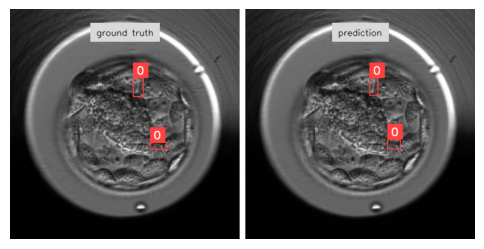

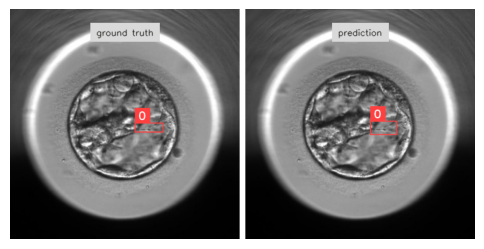

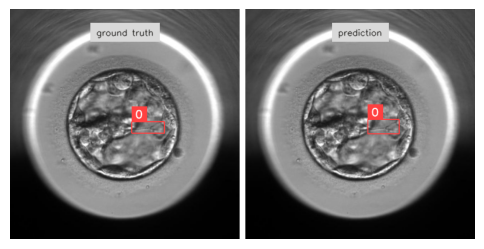

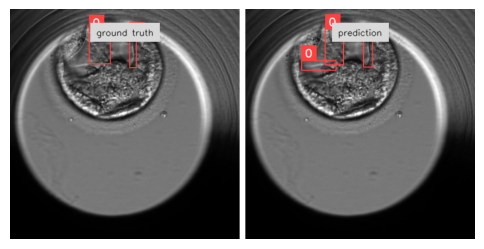

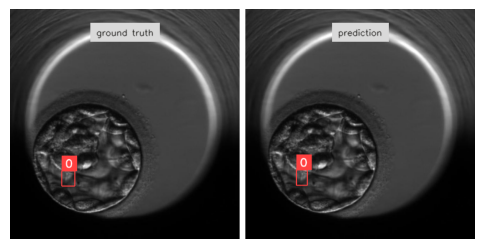

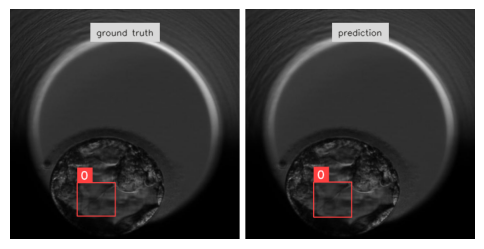

In [57]:
IMAGE_COUNT = 49

for i in range(IMAGE_COUNT):
    path, sourece_image, annotations = ds_test[i]

    image = Image.open(path)
    inputs = processor(image, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(**inputs)

    w, h = image.size
    results = processor.post_process_object_detection(
        outputs, target_sizes=[(h, w)], threshold=0.05)

    detections = sv.Detections.from_transformers(results[0]).with_nms(threshold=0.1)

    annotated_images = [
        annotate(sourece_image, annotations, ds_train.classes),
        annotate(sourece_image, detections, ds_train.classes)
    ]
    grid = sv.create_tiles(
        annotated_images,
        titles=['ground truth', 'prediction'],
        titles_scale=0.5,
        single_tile_size=(400, 400),
        tile_padding_color=sv.Color.WHITE,
        tile_margin_color=sv.Color.WHITE
    )
    sv.plot_image(grid, size=(6, 6))